Group Members: Dhruv, Rohan, Sarthak, Uday

In [2]:
!pip install yahoofinance
!pip install hmmlearn
!pip install seaborn
# !pip install pandas==1.5.1
# !pip install numpy==1.21.4

In [3]:
!pip install pyldavis

  Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
  Obtaining dependency information for numexpr from https://files.pythonhosted.org/packages/59/ca/b2e97c61df22c51bddda6dce76a9d9be799820ae082fc5321288967b448a/numexpr-2.8.7-cp39-cp39-win_amd64.whl.metadata
  Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
  Obtaining dependency information for gensim from https://files.pythonhosted.org/packages/d3/68/373da90a8b241e2603707c7aa4c8f47829a72729c6e9497f2bc604fa6a6a/gensim-4.3.2-cp39-cp39-win_amd64.whl.metadata
  Obtaining dependency information for smart-open>=1.8.1 from https://files.pythonhosted.org/packages/fc/d9/d97f1db64b09278aba64e8c81b5d322d436132df5741c518f3823824fae0/smart_open-6.4.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/24.0 MB 1.7 MB/s eta 0:00:15
   ---------------------------------------- 0.3/24.0 MB 3.4 MB/s eta 0:00:07
   - -------------------------------------- 

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.getcwd() + '/modules')
import seaborn as sns

# from modules.cross_validation import Pipeline, CustomCrossValidation
# from modules.directional_change import *
# from modules.hidden_markov_model import make_regime_plots
# from modules.logistic_regression import do_all_LR
# from modules.MixtureModels import *
# from modules.NaiveBayesClassifier import *
# from modules.svm import do_all_SVM
# from modules.timeseries import *
# from modules.trading_strategy import *
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

# plt.style.use('seaborn')
sns.set_theme()

# Experiments

Put self-contained code here for different experiments run. Easier to put in the report that way.

In [5]:
fomc_data = pd.read_csv('./fomc_documents.csv')

In [6]:
fomc_data.meeting_date = pd.to_datetime(fomc_data.meeting_date)
fomc_data = fomc_data[fomc_data.document_kind.isin(['historical_minutes', 'minutes', 'minutes_of_actions'])]
fomc_data['meeting_year'] = fomc_data.meeting_date.dt.year
fomc_data = fomc_data[fomc_data.meeting_year >= 1985]
# fomc_data.head()

In [7]:
def clean_text(text: str):
    text = text.lower()
    split_by = ''
    if 'the manager' in text and 'unanimous' in text:
        if text.index('the manager') > text.index('unanimous'):
            split_by = 'unanimous'
        else:
            split_by = 'the manager'
    elif 'the manager' in text:
        split_by = 'the manager'
    elif 'unanimous' in text:
        split_by = 'unanimous'
    else:
        raise ValueError('Neither in text!')

    return text.split(split_by)[1]

In [8]:
fomc_data.text = fomc_data.text.apply(clean_text)
fomc_data.head(1)

,document_kind,meeting_date,release_date,text,url,meeting_year
2947,minutes_of_actions,1985-02-13,1985-03-15,"vote, e. gerald corrigan was elected to serve...",https://www.federalreserve.gov/monetarypolicy/...,1985


In [15]:
!pip install nltk

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.5 MB 487.6 kB/s eta 0:00:04
     --- ------------------------------------ 0.1/1.5 MB 1.0 MB/s eta 0:00:02
     ------------ --------------------------- 0.5/1.5 MB 2.7 MB/s eta 0:00:01
     -------------------------------- ------- 1.2/1.5 MB 5.6 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 6.4 MB/s eta 0:00:00
  Obtaining dependency information for click from https://files.pythonhosted.org/packages/00/2e/d53fa4befbf2cfa713304affc7ca780ce4fc1fd8710527771b58311a3229/click-8.1.7-py3-none-any.whl.metadata
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/fc/85/0d1038f068900896a8590d6d0da198b90d31f731a39166a432aa2b92249b/regex-2023.10.3-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/42.0 

In [9]:
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

FOMC_STOP_WORDS = ["federal", "reserve", "board", "meeting", "committee", "minutes", "members"]
def custom_stop_words():
    stop_words = list(ENGLISH_STOP_WORDS) + FOMC_STOP_WORDS
    return stop_words

def join_tokens(tokens):
    return " ".join(tokens)


def remove_stop_words(tokens):
    stop_words = custom_stop_words()
    tokens = [word.lower() for word in tokens if word.isalpha()]
    result = [w.lower() for w in tokens if w.lower() not in stop_words]
    return result

In [10]:
def tokenize_data(df):
    df['tokens'] = df.text.apply(nltk.word_tokenize)
    df["tokens_wo_stop"] = df.tokens.apply(remove_stop_words)
    df["new_text"] = df.tokens_wo_stop.apply(join_tokens)
    return df

def manual_tf_idf(text: pd.Series):
    """
    This function manually computes the TF-IDF values for the given column of
    documents, in order to avoid the incorrect computations performed by
    sklearn's native implementation.

    @param text(pd.Series): the (n, 1) column of n documents for which TF-IDF
                            is being computed
    @returns tf_idf_df(np.ndarray): the (n, n_words) representing TF-IDF values
    """
    # Get number of documents
    n_docs = text.shape[0]
    from sklearn.feature_extraction.text import CountVectorizer
    # Generate bag-of-words matrix
    def_vectorizer = CountVectorizer(token_pattern='[a-zA-Z]+')
    word_bow_matrix = def_vectorizer.fit_transform(text)
    word_bow_df = pd.DataFrame(
        word_bow_matrix.toarray(),
        columns=def_vectorizer.get_feature_names_out()
    )

    # Create TF matrix
    tf_df = word_bow_df / word_bow_df.sum(axis=1).values.reshape(n_docs, 1)

    # Compute IDF values
    idf = np.log(n_docs / (word_bow_df / word_bow_df.values).sum(axis=0))

    # Manually create TF-IDF matrix
    tfidf_df = tf_df * idf

    return tfidf_df

In [11]:
fomc_data = tokenize_data(fomc_data)

In [12]:
test_data = fomc_data[fomc_data["meeting_date"] > datetime(2019, 12, 31)]
train_data = fomc_data[fomc_data["meeting_date"] <= datetime(2019, 12, 31)]

In [13]:
from gensim.corpora import Dictionary
def generate_gensim_input(df, dict_gensim_statements=None):
  gensim_statements = df["tokens_wo_stop"] .tolist()
  if dict_gensim_statements is None: 
    dict_gensim_statements = Dictionary(gensim_statements)
  bow_gensim_statements = [dict_gensim_statements.doc2bow(d) for d in gensim_statements]
  return gensim_statements, dict_gensim_statements, bow_gensim_statements

In [14]:
# !pip install gensim# !pip install gensim
import gensim
gensim_statements, dict_gensim_statements, bow_gensim_statements = generate_gensim_input(train_data)
test_gensim_statements, _, test_bow_gensim_statements = generate_gensim_input(test_data, dict_gensim_statements)

In [15]:
from gensim.models import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel

tfidf_model = TfidfModel(bow_gensim_statements)
tfidf_statements = tfidf_model[bow_gensim_statements]
test_tfidf_statements = tfidf_model[test_bow_gensim_statements]


In [16]:
from gensim.matutils import corpus2dense, corpus2csc
def convert_to_dense_tfidf_matrix( bow, num_docs, num_terms, tfidf_model=None):
  if tfidf_model is None: 
    tfidf_model = TfidfModel(bow)
  tfidf_statements = tfidf_model[bow]  
  corpus_tfidf_dense = corpus2dense(tfidf_statements, num_terms, num_docs)
  return tfidf_model, corpus_tfidf_dense.T


In [17]:
num_terms = len(dict_gensim_statements.keys())
tfidf_train, corpus_tfidf_dense = convert_to_dense_tfidf_matrix(bow_gensim_statements, len(gensim_statements), num_terms)
_, test_corpus_dense = convert_to_dense_tfidf_matrix(test_bow_gensim_statements, len(test_gensim_statements), num_terms, tfidf_model=tfidf_train)

In [18]:
# num_docs = dict_gensim_statements.num_docs
# num_terms = len(dict_gensim_statements.keys())
# corpus_tfidf_dense = corpus2dense(tfidf_statements, num_terms, num_docs)
# # corpus_tfidf_sparse = corpus2csc(tfidf_statements, num_terms, num_docs=num_docs)
# test_corpus_dense = corpus2dense(test_tfidf_statements, num_terms, len(test_gensim_statements))
# num_terms = len(dict_gensim_statements.keys())
# num_terms

In [19]:
!pip install wordcloud

In [20]:
from wordcloud import WordCloud

def wordcloud_clusters(model, vectors, features, n_top_words=50):
  num_clouds = len(np.unique(model.labels_))
  fig, axs = plt.subplots(num_clouds, 1, figsize=(6.4, 6.4 * num_clouds))
  axs = axs.flatten()

  for i, cluster in enumerate(np.unique(model.labels_)):
    ax = axs[i]
    size = {}
    words = vectors[model.labels_ == cluster].sum(axis=0)
    largest = words.argsort()[::-1]
    for j in range(0, n_top_words):
        size[features[largest[j]]] = abs(words[largest[j]])
    wc = WordCloud(
        background_color="white",
        max_words=100,
        width=500,
        height=300
    )
    wc.generate_from_frequencies(size)
    # plt.figure(figsize=(4, 4))
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f'Cluster = {cluster}')

  fig.tight_layout()

In [36]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
def fit_kmeans(corpus, dictionary, K=3, word_cloud = True, to_array=False):
    fomc_norm = preprocessing.normalize(corpus)
    if to_array:
        fomc_norm = fomc_norm.toarray()

    k_means_fomc = KMeans(n_clusters=K)
    k_means_fomc.fit(fomc_norm)
    sizes_df = pd.DataFrame.from_dict({
        'CLUSTER': [i for i in range(K)],
        'CLUSTER_SIZE': [np.sum(k_means_fomc.labels_ == i) for i in range(K)],
    }).set_index('CLUSTER')
    display(sizes_df)
    if word_cloud:
        wordcloud_clusters(
        k_means_fomc,
        fomc_norm,
        dictionary
    )
    return k_means_fomc

TFIDF-dense matrix with K = 2


,CLUSTER_SIZE
CLUSTER,
0,176
1,105


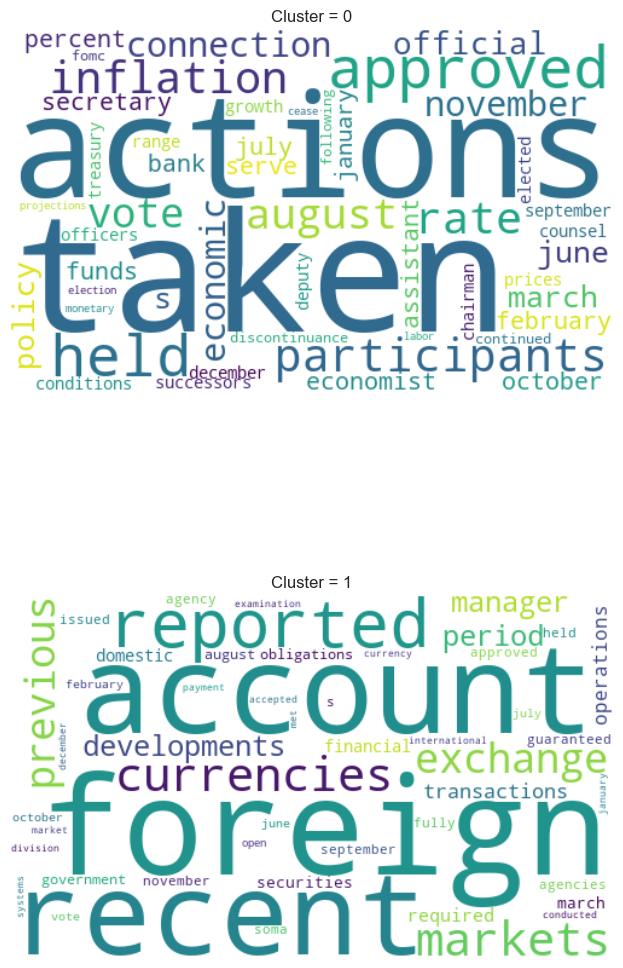

In [37]:
print("TFIDF-dense matrix with K = 2")
kmeans_cl = fit_kmeans(corpus_tfidf_dense, dict_gensim_statements, K=2)

In [23]:
# print("TFIDF-sparse matrix with K = 2")
# fit_kmeans(corpus_tfidf_sparse.T, dict_gensim_statements, K=2, to_array=True)

In [22]:
# tfidf_df = manual_tf_idf(train_data.new_text)
# fit_kmeans(tfidf_df.values, tfidf_df.columns.tolist(), K=2)

In [38]:
cluster_labels = kmeans_cl.predict(preprocessing.normalize(corpus_tfidf_dense))
train_data["kmeans_labels"] = cluster_labels
train_data["kmeans_labels"].value_counts()

0    176
1    105
Name: kmeans_labels, dtype: int64

In [25]:
cluster_labels = kmeans_cl.predict(preprocessing.normalize(test_corpus_dense))
test_data["kmeans_labels"] = cluster_labels
test_data["kmeans_labels"].value_counts()

0    28
Name: kmeans_labels, dtype: int64

In [26]:
def generate_labels(df, date_col, label_col, name="train", start=datetime(1985, 1, 1), end=datetime(2019, 12, 31)):
    full_date_range = pd.date_range(start=start, end=end)
    label_data = pd.DataFrame().from_dict({date_col:full_date_range})
    label_data = pd.merge(label_data, df[[date_col, label_col]], on=date_col, how="left").fillna(method="bfill")
    # print(label_data.tail())
    label_data[label_col] = label_data[label_col].fillna(method="ffill")
    label_data[label_col] = label_data[label_col].astype("int")
    # print(label_data.tail())
    # label_data.to_csv("./assets/"+ label_col + "_"+name+"_"+ ".csv")
    return label_data

In [36]:
label_data = generate_labels(train_data, "meeting_date", "kmeans_labels")

In [37]:
label_data = generate_labels(test_data, "meeting_date", "kmeans_labels", name="test" ,start=datetime(2020,1,1), end=datetime(2023, 6, 14))

In [27]:
from sklearn.model_selection import KFold
def num_topics_cross_val(tfidf_statements, dict_gensim_statements, gensim_statements, num_topics_list = [2, 5, 7, 10], n_splits=5, coh_score = "c_v"):
    kf = KFold(n_splits=n_splits)
    rank_dict = dict()
    for num_topics in num_topics_list:
        avg_coherence = 0
        for train_idx, test_idx in kf.split(tfidf_statements):
            train_stmts = [tfidf_statements[i] for i in train_idx]
            model = Nmf(train_stmts, num_topics=num_topics, id2word=dict_gensim_statements, passes=5, random_state=42)
            coherence_model = CoherenceModel(model=model, texts=gensim_statements, dictionary=dict_gensim_statements, coherence=coh_score)
            coherence = coherence_model.get_coherence()
            avg_coherence += coherence
        avg_coherence /= kf.get_n_splits()
        rank_dict[num_topics] = avg_coherence
        # print(f"Num Topics: {num_topics}, Average Coherence: {avg_coherence:.4f}")     
    return list(sorted(rank_dict.items(), key=lambda item: item[1], reverse=True))

def generate_topic_distribution_matrix(model, corpus, num_docs, num_topics):
    doc_mat = np.zeros(shape=(num_docs, num_topics))
    for i in range(num_docs):
        topic_list = model.get_document_topics(corpus[i], minimum_probability=0)
        for tup in topic_list:
            doc_mat[i][tup[0]] = tup[1]
    return doc_mat

def assign_topic_to_documents(model, corpus, num_docs, num_topics):
    topic_mat = np.zeros(num_docs, dtype="int64")
    for i in range(num_docs):
        topic_list = model.get_document_topics(corpus[i], minimum_probability=0)
        topic_list = sorted(topic_list, key=lambda x: x[1], reverse=True)
        topic_mat[i] = topic_list[0][0]
    return topic_mat


In [31]:
# rank_list = num_topics_cross_val(tfidf_statements, dict_gensim_statements)
# cv_num_topics = rank_list[0][0]
# cv_num_topics

In [29]:
from topic_modeling import TopicModel
topicmod = TopicModel(tfidf_statements, dict_gensim_statements, gensim_statements)
topicmod.fit()

In [65]:
um_topicmod.cv_topics_list

[(2, -0.7881428697768916),
 (5, -1.1313553093588373),
 (10, -1.23791267475173),
 (7, -1.3901598944223061)]

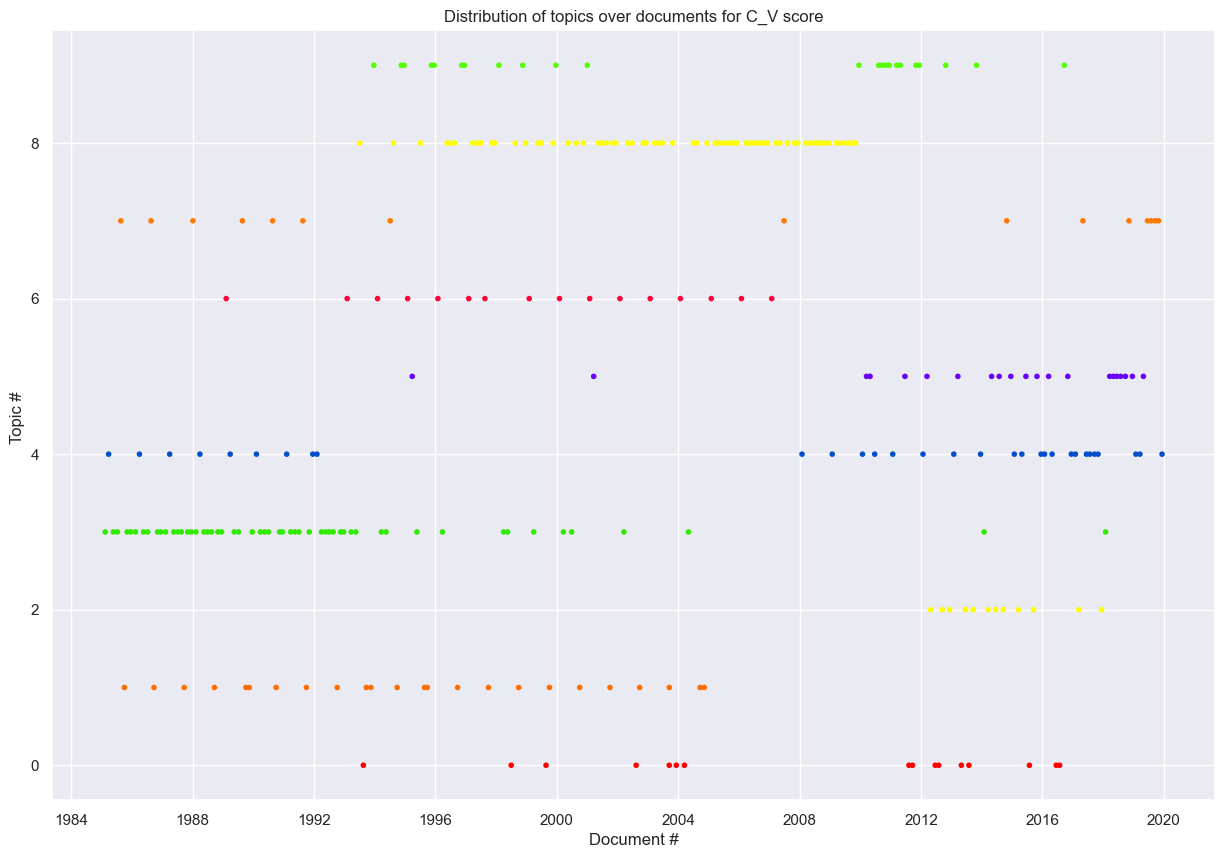

In [108]:
fig, ax =plt.subplots(1, figsize=(15, 10))
ax.scatter(y=topicmod.topic_mat, x=train_data["meeting_date"], marker=".", c=topicmod.topic_mat, cmap="prism")
ax.set_xlabel("Document #")
ax.set_ylabel("Topic # ")
plt.title("Distribution of topics over documents for C_V score")
plt.show()

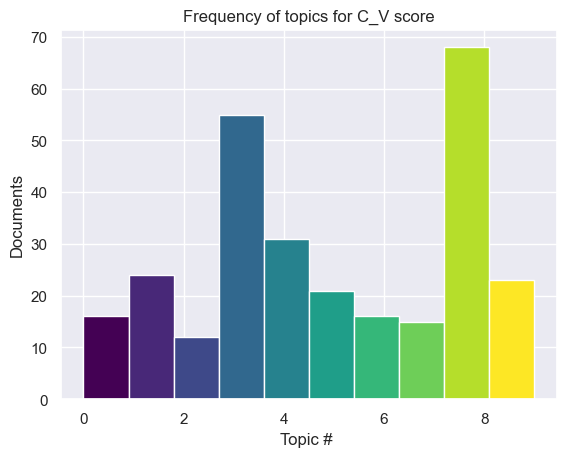

In [136]:
# fig, ax =plt.subplots(1, figsize=(15, 10))
# ax.hist(topicmod.topic_mat)

fig, ax = plt.subplots()
counts, bins, patches = ax.hist(topicmod.topic_mat, bins=10)

# Use a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
ax.set_ylabel("Documents")
ax.set_xlabel("Topic # ")
plt.title("Frequency of topics for C_V score")
plt.show()

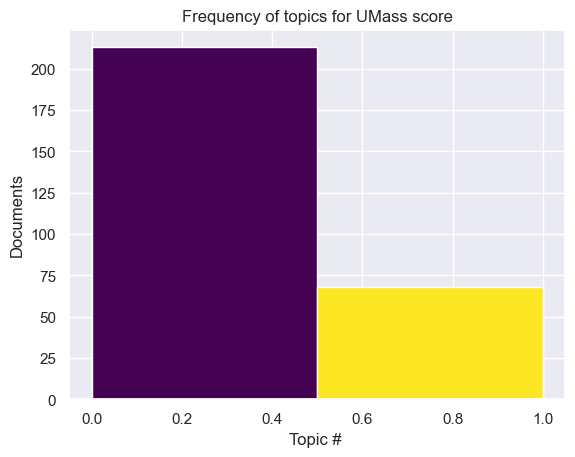

In [135]:
fig, ax = plt.subplots()
counts, bins, patches = ax.hist(um_topicmod.topic_mat, bins=2)

# Use a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(patches)))

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i])
ax.set_ylabel("Documents")
ax.set_xlabel("Topic # ")
plt.title("Frequency of topics for UMass score")
plt.show()

C:\Users\prajp\AppData\Local\Temp\ipykernel_9956\2913377399.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


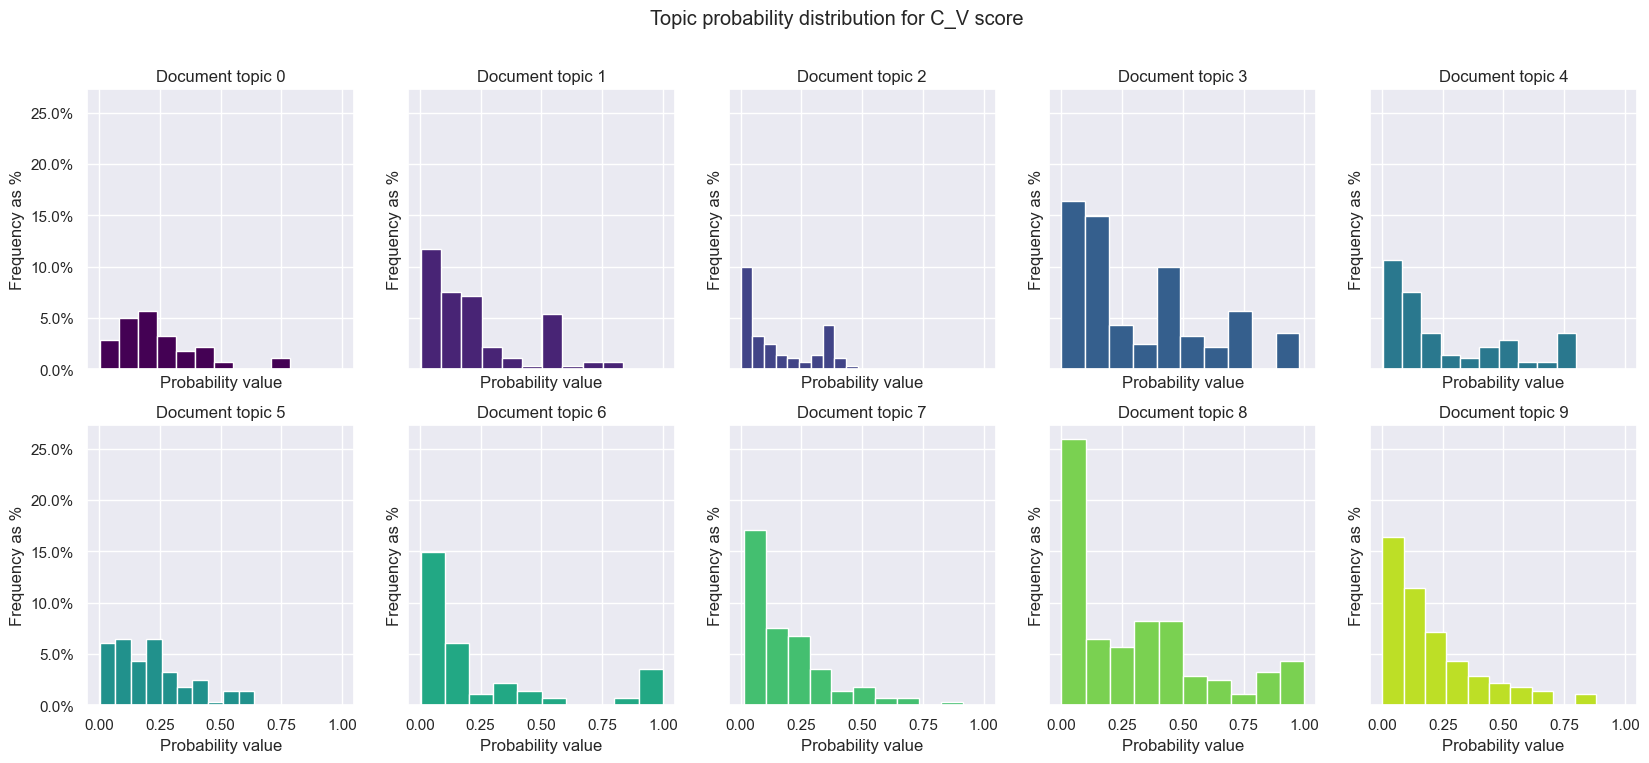

In [112]:
from matplotlib.ticker import PercentFormatter
import matplotlib.cm as cm

fig, ax = plt.subplots(2, 5, figsize=(20, 8),sharey=True, sharex=True)
k = 0
cmap = cm.get_cmap('viridis')
for i in range(2):
    for j in range(5):
        df = topicmod.doc_mat[:, k][topicmod.doc_mat[:, k].nonzero()]
        ax[i, j].hist(df, weights= np.ones_like(df)/len(topicmod.doc_mat[:,k]), color=cmap(k/10))
        ax[i, j].set_title("Document topic " + str(k))
        ax[i, j].set_xlabel("Probability value")
        ax[i, j].set_ylabel("Frequency as %")
        k=k+1
        ax[i, j].yaxis.set_major_formatter(PercentFormatter(1))
plt.suptitle("Topic probability distribution for C_V score")
plt.show()


In [46]:
import pyLDAvis

In [61]:
doc_topic_dists.shape

(10, 281)

In [62]:
topic_term_dists = topicmod.cv_model.get_topics()  # transpose to make shape (num_terms, num_topics)
doc_topic_dists = topicmod.doc_mat# cv_model.get_document_topics(topicmod.tfidf_mat, minimum_probability=0)
# doc_topic_dists = [[tup[1] for tup in lst] for lst in doc_topic_dists]  # convert list of tuples to just list
doc_lengths = [len(doc) for doc in gensim_statements]
vocab = list(dict_gensim_statements.token2id.keys())
term_frequency = dict_gensim_statements.cfs

# Use pyLDAvis
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=list(term_frequency.values())
)

pyLDAvis.display(vis_data)

In [138]:
topicmod.cv_model.show_topics(num_words=10)

[(0,
  '0.031*"june" + 0.011*"inflation" + 0.009*"economic" + 0.009*"labor" + 0.008*"policy" + 0.007*"pace" + 0.007*"conditions" + 0.006*"participants" + 0.006*"growth" + 0.006*"quarter"'),
 (1,
  '0.067*"august" + 0.036*"september" + 0.018*"april" + 0.013*"s" + 0.009*"inflation" + 0.009*"participants" + 0.008*"business" + 0.008*"selection" + 0.008*"agency" + 0.007*"obligations"'),
 (2,
  '0.027*"participants" + 0.021*"projections" + 0.018*"financial" + 0.017*"rate" + 0.017*"percent" + 0.016*"inflation" + 0.014*"domestic" + 0.011*"october" + 0.010*"appropriate" + 0.009*"unemployment"'),
 (3,
  '0.089*"taken" + 0.081*"actions" + 0.064*"march" + 0.057*"february" + 0.056*"approved" + 0.052*"held" + 0.033*"vote" + 0.021*"chairman" + 0.018*"required" + 0.016*"august"'),
 (4,
  '0.014*"deputy" + 0.011*"secretary" + 0.011*"assistant" + 0.011*"counsel" + 0.010*"economist" + 0.010*"rate" + 0.009*"general" + 0.009*"rates" + 0.008*"continued" + 0.008*"policy"'),
 (5,
  '0.018*"soma" + 0.013*"infl

June inflation economic labor policy - Labor Markets and pace of inflation

Summer business obligations and agency selection

Projections of inflation rate and domestic participants

First half of year, actions taken and approved by FOMC

Junk topic? (deputy, secretary, assistant)

System Open Market Account (SOMA) first meetings of year, growth, inflation

elections and successors, discontinuance

second half of year, actions taken

foreign exchange and currencies

treasury and security transactions


In [30]:
um_topicmod = TopicModel(tfidf_statements, dict_gensim_statements, gensim_statements, cv_score="u_mass")
um_topicmod.fit()

In [31]:
um_topicmod.cv_model.show_topics(num_words=10)

[(0,
  '0.017*"foreign" + 0.014*"recent" + 0.014*"account" + 0.012*"taken" + 0.012*"reported" + 0.012*"markets" + 0.011*"actions" + 0.011*"developments" + 0.011*"period" + 0.010*"approved"'),
 (1,
  '0.012*"participants" + 0.012*"inflation" + 0.011*"rate" + 0.009*"s" + 0.009*"economic" + 0.008*"policy" + 0.007*"securities" + 0.007*"percent" + 0.005*"funds" + 0.005*"growth"')]

In [32]:
np.unique(um_topicmod.doc_mat, return_counts=True)

(array([0.        , 0.01516361, 0.02660635, 0.02863453, 0.04172121,
        0.05131308, 0.05188997, 0.05257573, 0.06127839, 0.06422861,
        0.06828108, 0.06914899, 0.07116476, 0.07133884, 0.07398667,
        0.07416371, 0.07487259, 0.07695203, 0.07766438, 0.07846327,
        0.08530699, 0.08603201, 0.08699726, 0.0871052 , 0.09053817,
        0.09324202, 0.09424737, 0.09848492, 0.10375705, 0.10454726,
        0.10804463, 0.10984255, 0.11397938, 0.1154209 , 0.11588662,
        0.12403467, 0.12472613, 0.12515562, 0.12692676, 0.12969691,
        0.13087886, 0.13144129, 0.13307084, 0.13910732, 0.14581784,
        0.14750722, 0.14908639, 0.14984572, 0.15522785, 0.1572109 ,
        0.1601363 , 0.16042046, 0.16401587, 0.16858696, 0.17392191,
        0.18323437, 0.20429712, 0.20559718, 0.21053678, 0.21631029,
        0.21711495, 0.22345493, 0.22657674, 0.22697663, 0.2330202 ,
        0.23873655, 0.24182738, 0.24450856, 0.2498124 , 0.25470721,
        0.26732774, 0.28358797, 0.29197479, 0.29

foregin account and market developments

economic policy and growth

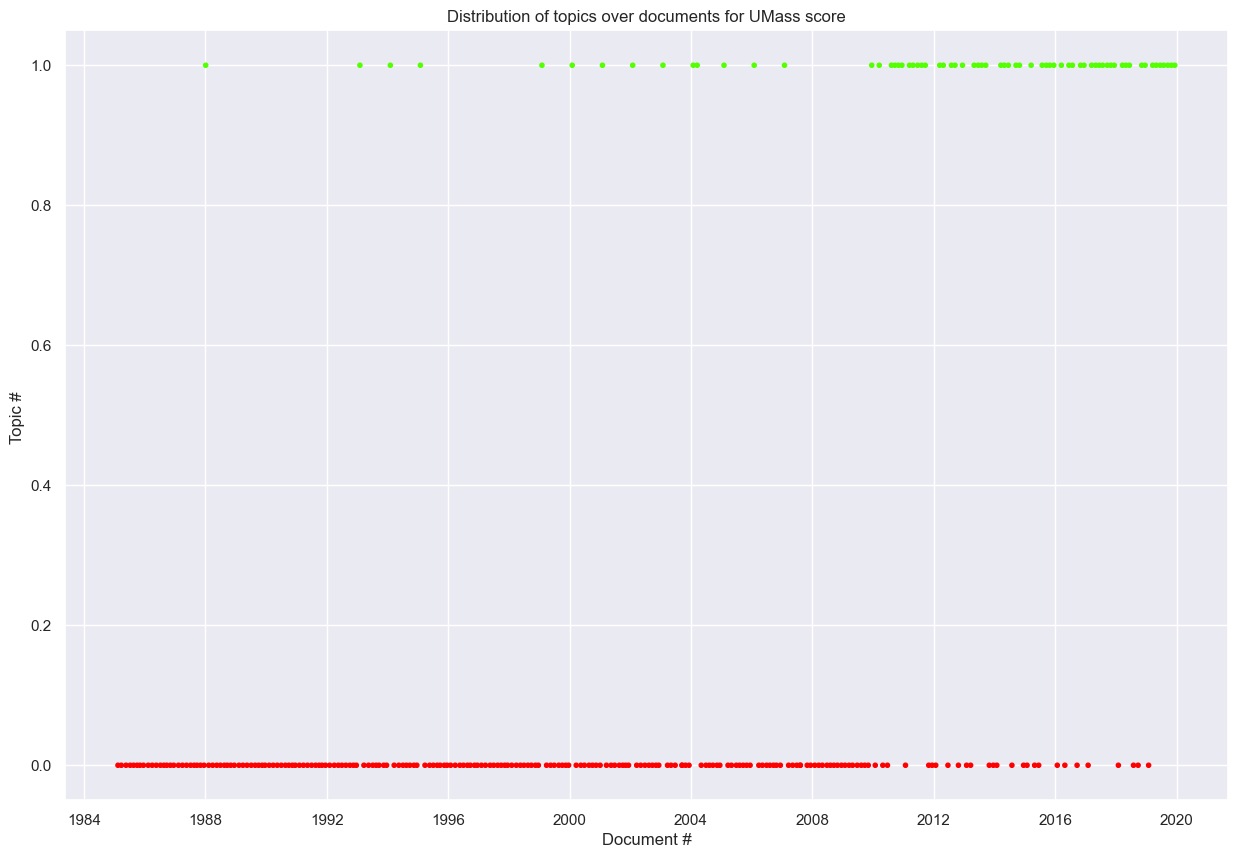

In [107]:
fig, ax =plt.subplots(1, figsize=(15, 10))
ax.scatter(y=um_topicmod.topic_mat, x=train_data["meeting_date"], marker=".",c=um_topicmod.topic_mat, cmap="prism")
ax.set_xlabel("Document #")
ax.set_ylabel("Topic # ")
plt.title("Distribution of topics over documents for UMass score")
plt.show()

In [ ]:
topicmod.cv_model.show_topics(num_words=5)

[(0,
  '0.031*"june" + 0.011*"inflation" + 0.009*"economic" + 0.009*"labor" + 0.008*"policy"'),
 (1,
  '0.067*"august" + 0.036*"september" + 0.018*"april" + 0.013*"s" + 0.009*"inflation"'),
 (2,
  '0.027*"participants" + 0.021*"projections" + 0.018*"financial" + 0.017*"rate" + 0.017*"percent"'),
 (3,
  '0.089*"taken" + 0.081*"actions" + 0.064*"march" + 0.057*"february" + 0.056*"approved"'),
 (4,
  '0.014*"deputy" + 0.011*"secretary" + 0.011*"assistant" + 0.011*"counsel" + 0.010*"economist"'),
 (5,
  '0.018*"soma" + 0.013*"inflation" + 0.013*"january" + 0.011*"participants" + 0.011*"rate"'),
 (6,
  '0.039*"connection" + 0.037*"official" + 0.020*"discontinuance" + 0.019*"officers" + 0.019*"cease"'),
 (7,
  '0.022*"taken" + 0.020*"actions" + 0.020*"july" + 0.016*"november" + 0.014*"rate"'),
 (8,
  '0.074*"foreign" + 0.060*"account" + 0.055*"previous" + 0.052*"exchange" + 0.052*"currencies"'),
 (9,
  '0.050*"november" + 0.033*"september" + 0.019*"securities" + 0.017*"transactions" + 0.017*

In [ ]:
um_topicmod.cv_model.show_topics(num_words=5)

[(0,
  '0.017*"foreign" + 0.014*"recent" + 0.014*"account" + 0.012*"taken" + 0.012*"reported"'),
 (1,
  '0.012*"participants" + 0.012*"inflation" + 0.011*"rate" + 0.009*"s" + 0.009*"economic"')]

C:\Users\prajp\AppData\Local\Temp\ipykernel_9956\1088444030.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


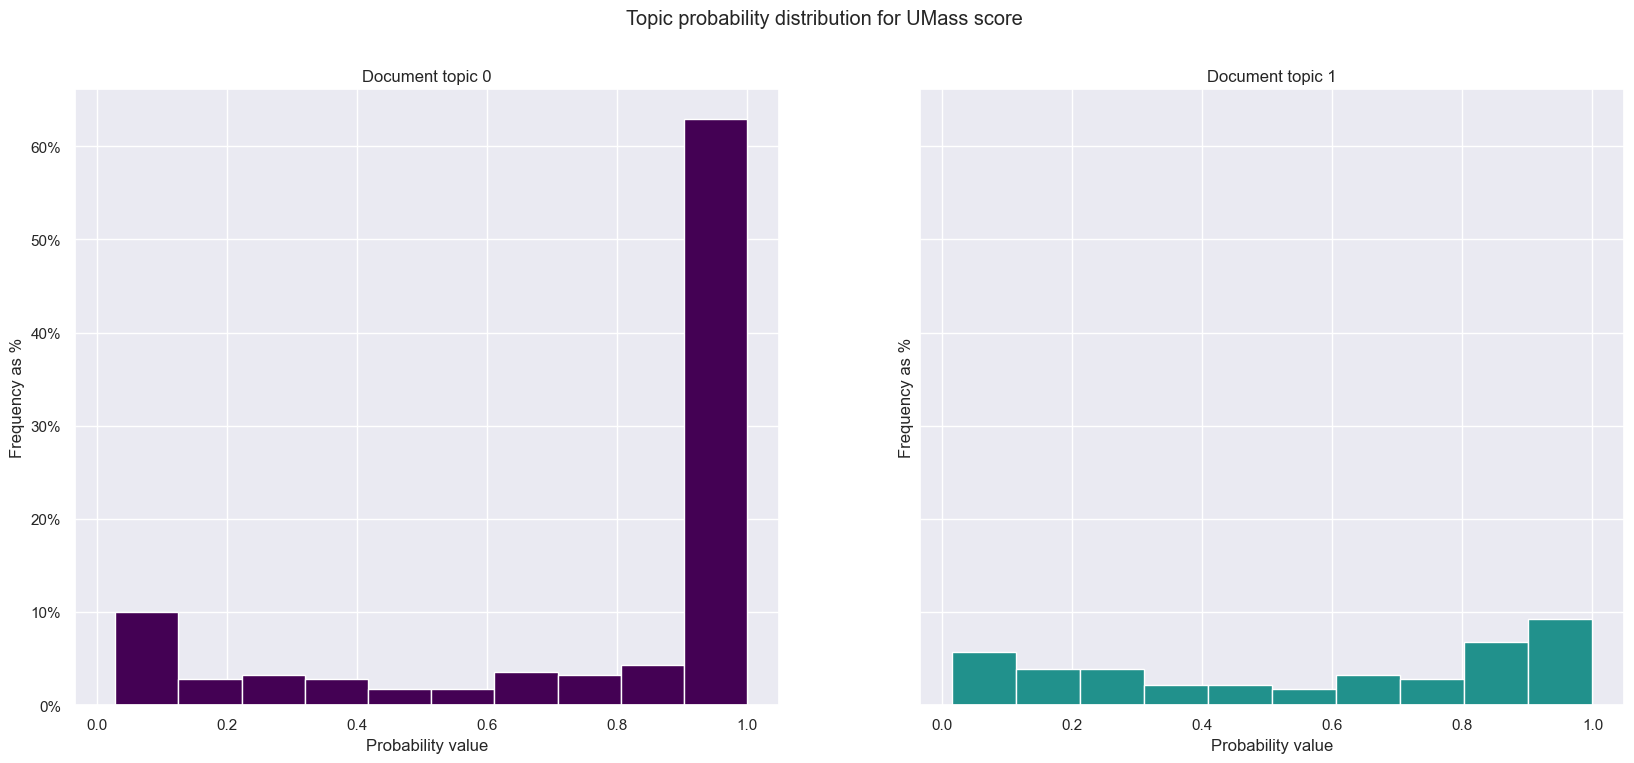

In [121]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(1, 2, figsize=(20, 8),sharey=True, sharex=True)
cmap = cm.get_cmap('viridis')
k = 0
for j in range(2):
        df = um_topicmod.doc_mat[:, k][um_topicmod.doc_mat[:, k].nonzero()]
        ax[j].hist(df, weights= np.ones_like(df)/len(um_topicmod.doc_mat[:,k]), color=cmap(k/2))
        ax[j].set_title("Document topic " + str(k))
        ax[j].set_xlabel("Probability value")
        k=k+1
        ax[j].yaxis.set_major_formatter(PercentFormatter(1))
        ax[j].set_ylabel("Frequency as %")
plt.suptitle("Topic probability distribution for UMass score")
plt.show()


In [122]:
topic_term_dists = um_topicmod.cv_model.get_topics()  # transpose to make shape (num_terms, num_topics)
doc_topic_dists = um_topicmod.doc_mat# cv_model.get_document_topics(topicmod.tfidf_mat, minimum_probability=0)
# doc_topic_dists = [[tup[1] for tup in lst] for lst in doc_topic_dists]  # convert list of tuples to just list
doc_lengths = [len(doc) for doc in gensim_statements]
vocab = list(dict_gensim_statements.token2id.keys())
term_frequency = dict_gensim_statements.cfs

# Use pyLDAvis
vis_data = pyLDAvis.prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=list(term_frequency.values())
)

pyLDAvis.display(vis_data)

In [ ]:
kmeans_topic = fit_kmeans(doc_mat, dict_gensim_statements, K=2, word_cloud=False)

,CLUSTER_SIZE
CLUSTER,
0,116
1,165


In [34]:
np.unique(um_topicmod.topic_mat, return_counts=True)

(array([0, 1], dtype=int64), array([213,  68], dtype=int64))

In [ ]:
cluster_labels = kmeans_topic.predict(preprocessing.normalize(doc_mat))
train_data["topic_labels"] = cluster_labels
train_data["topic_labels"].replace({0:1, 1:0}, inplace=True)

In [ ]:
train_data["topic_labels"].value_counts()

0    165
1    116
Name: topic_labels, dtype: int64

In [ ]:
label_data = generate_labels(train_data, "meeting_date", "topic_labels", name="train")

In [ ]:
def train_nmf_coh(num_topics=5, cscore="c_v"):
    mod = Nmf(corpus=tfidf_statements, id2word=dict_gensim_statements, num_topics=num_topics)
    coh = CoherenceModel(mod, texts=gensim_statements, dictionary=dict_gensim_statements, coherence=cscore)
    return coh.get_coherence_per_topic()
print("2 C_V", train_nmf_coh(2))
print("5 C_V", train_nmf_coh(5))
print("2 u_mass", train_nmf_coh(2, "u_mass"))
print("5 u_mass", train_nmf_coh(5, "u_mass"))

2 C_V [0.2552235881666249, 0.31428810779092325]
5 C_V [0.4142702025434212, 0.37541512706062485, 0.45197471526812727, 0.3458453250777213, 0.23244946900802438]
2 u_mass [-0.6571598240292478, -1.5052608068847222]
5 u_mass [-1.4524116414520138, -0.5040147502388098, -4.924320556871501, -0.5294542090042155, -2.764774775279142]


# Pipeline With Cross-Validation

In [ ]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8]
}

In [ ]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':12}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.1305995614876654, 'profit': 0.11294466215834031, 'sharpe': 0.45221807530971014}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.13110416467530533, 'profit': 0.09080363474279118, 'sharpe': 0.30836236577557885}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.14305879638395586, 'profit': 0.08665954285897826, 'sharpe': 0.2944372978219167}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'theta': 0.01}
Iteration: 4 of 45: Training complete.
Iteration: 4 of 45: Loss: {'drawdown': 0.095926414383

In [ ]:
""" Optimal parameters and optimal value of the loss function. """

cv.get_optimal_loss()

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124405,
 'parameters': {'DC_indicator': 'R', 'epsilon': 0.8, 'theta': 0.01}}

In [ ]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


In [ ]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.08494409644887346,
 'profit': 0.3578784282703851,
 'sharpe': 0.8304325174124405}

In [ ]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


In [ ]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.10658049858278516,
 'profit': 0.13305612063278272,
 'sharpe': 0.3877989114498797}

In [ ]:
""" If you want to look at all the grid search results. """
# sorted(cv.get_losses(), key=lambda d: d['profit'])

' If you want to look at all the grid search results. '

In [ ]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.1543405840247128,
 'profit': 0.37101175204318526,
 'sharpe': 0.47998209967808686}

In [ ]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.15456424726434365,
 'profit': 0.3541043469635792,
 'sharpe': 0.5213167068175325}

In [ ]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.210407488924396}

In [ ]:
""" If you want to get the results in Latex """
# print(cv.get_results_in_latex('Naive Bayes Cross-Validation Results'))

' If you want to get the results in Latex '

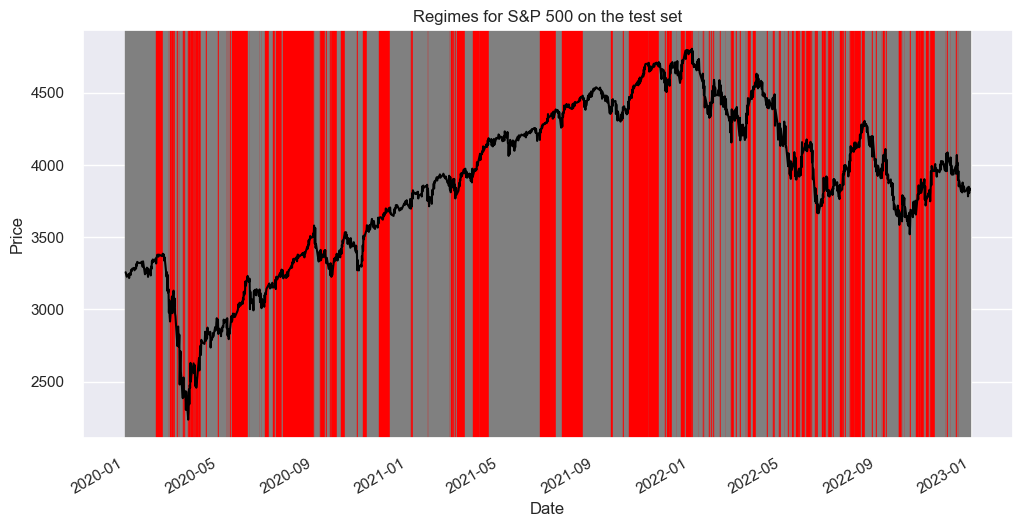

In [ ]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(12,6))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"Regimes for S&P 500 on the test set")
ax.set_ylabel("Price")
plt.show()

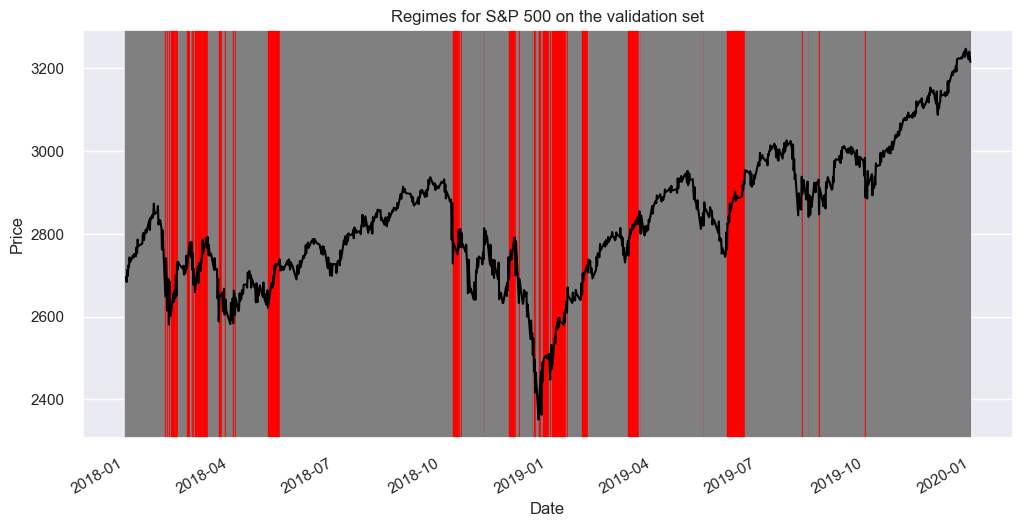

In [ ]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(12,6))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"Regimes for S&P 500 on the validation set")
ax.set_ylabel("Price")
plt.show()

## Visualizing DC indicators

In [ ]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

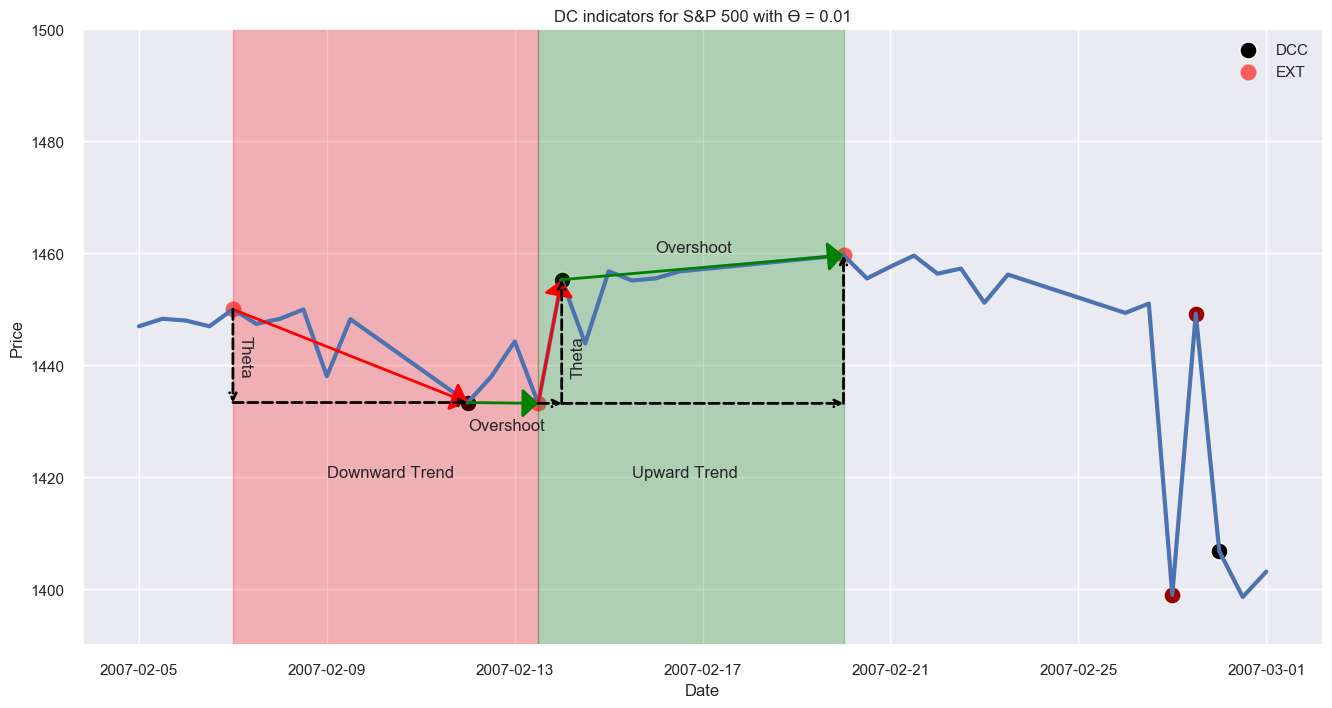

In [ ]:
# example
sample_ts = df_ts[1050:1085]
first_date = sample_ts.index[0]
last_date = sample_ts.index[-1]

dcc = []
dcc_idx = []
ext = []
ext_idx = []

for i in range(len(model.dc['train'])):
    dcc.append(model.dc['train'][i][1])
    dcc_idx.append(model.dc['train'][i][0])
    ext.append( model.dc['train'][i][3] )
    ext_idx.append( model.dc['train'][i][2] )

dcc = pd.Series( data=dcc, index = dcc_idx)
ext = pd.Series( data=ext, index = ext_idx)

sample_dcc = dcc.loc[first_date:last_date]#.index
sample_ext = ext.loc[first_date:last_date]#.index

fig,ax = plt.subplots(figsize=(16,8))
features = model.dc['train']
sns.lineplot(data=sample_ts, linewidth=3)
sns.scatterplot(x = sample_dcc.index, y = sample_dcc, color='black', s=150, label='DCC',alpha=1, ax=ax)
sns.scatterplot(x = sample_ext.index, y = sample_ext, color='red', s=150, label='EXT',alpha=0.6, ax=ax)

annotate_plot(ax, sample_ext, sample_dcc)

ax.set_title(f"DC indicators for S&P 500 with ϴ = {model.theta}")
ax.set_ylabel("Price")
ax.set_ylim([1390, 1500])
ax.legend()
plt.show()

## Regime Characteristic Plots

In [ ]:
model = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
model.fit()
regimes_test = strat_test.regimes_test
regimes_valid = strat_test.regimes_valid

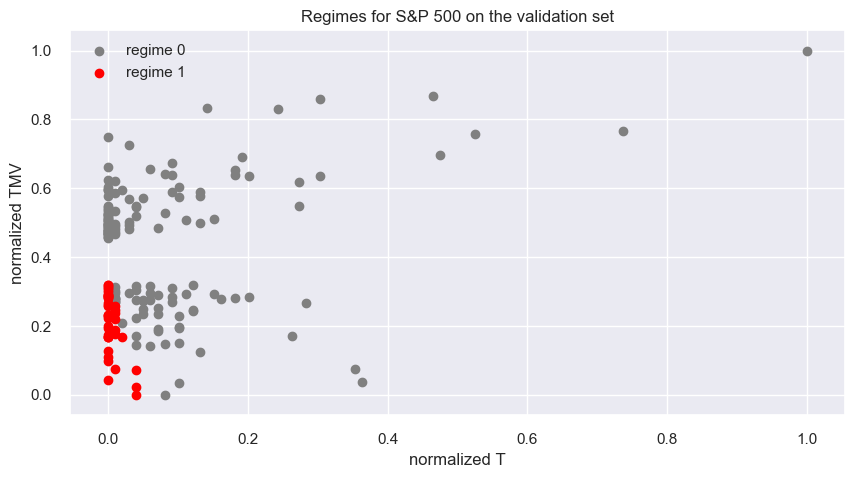

In [ ]:
make_regime_plots(regimes_valid, model.tmv['valid'], model.T['valid'], 'S&P 500', 'validation')

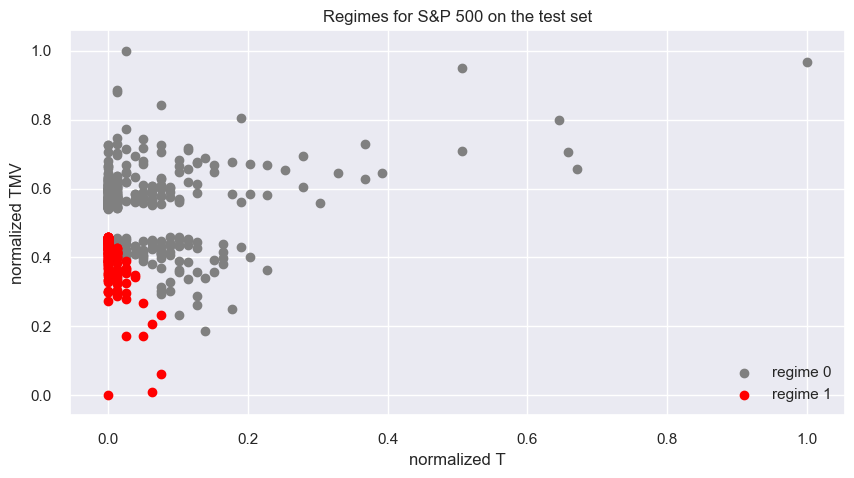

In [ ]:
make_regime_plots(regimes_test, model.tmv['test'], model.T['test'], 'S&P 500', 'test')

## Comparing to Logistic Regression

In [ ]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['logistic_regression']
}

In [ ]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv2 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv2.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.15476858537838412, 'profit': 0.05660923866428269, 'sharpe': 0.27909948638735205}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.3511267874220865}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'logistic_regression', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.28659436450957937}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'l

In [ ]:
""" Optimal parameters and optimal value of the loss function. """

cv2.get_optimal_loss()

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407,
 'parameters': {'DC_indicator': 'T',
  'epsilon': 0.6,
  'model': 'logistic_regression',
  'theta': 0.019999999999999997}}

In [ ]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv2.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [ ]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407}

In [ ]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv2.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [ ]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.197107948275105,
 'profit': 0.05202371492608826,
 'sharpe': 0.23050795640032237}

In [ ]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.2701506503824544,
 'profit': 0.40691312858269235,
 'sharpe': 0.46022959091991317}

In [ ]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.25873230856297735,
 'profit': 0.5019380257164072,
 'sharpe': 0.6115277904174444}

In [ ]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

In [ ]:
""" If you want to get the results in Latex """
# print(cv2.get_results_in_latex(
#     loss_columns=['profit', 'drawdown', 'sharpe'],
#     parameter_columns=['theta', 'epsilon', 'DC_indicator'],
#     caption='Logistic Regression Cross-Validation Results'))

' If you want to get the results in Latex '

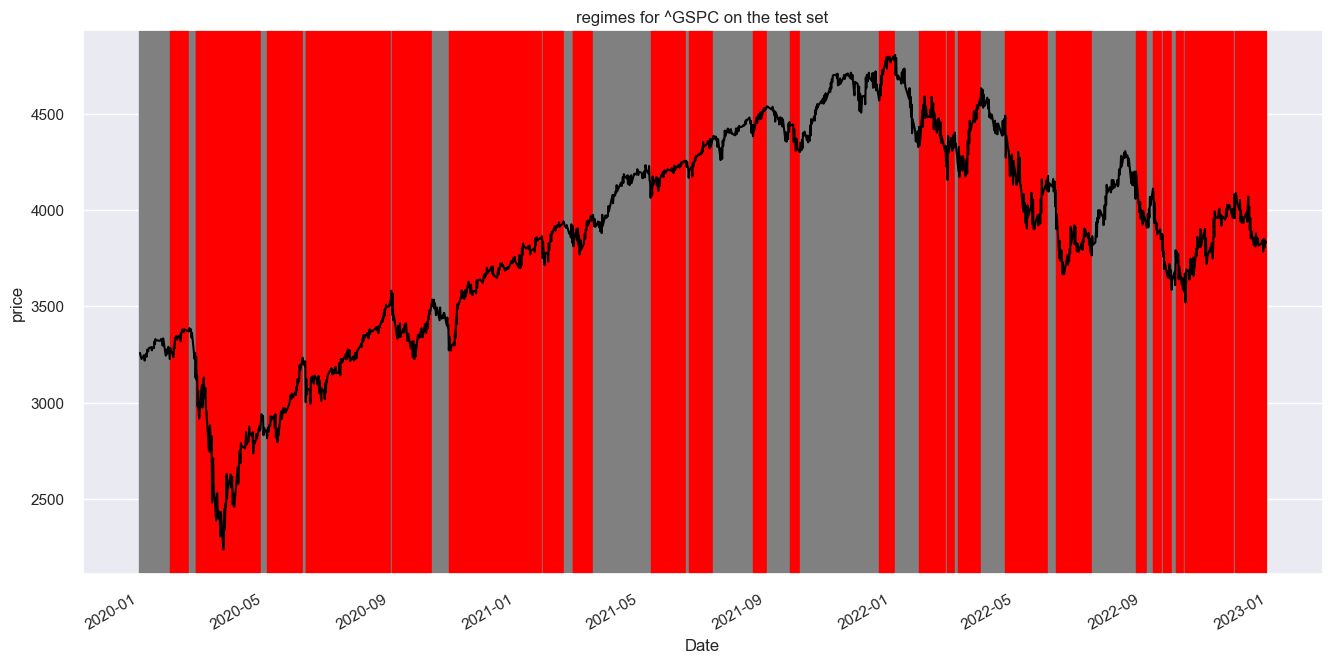

In [ ]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

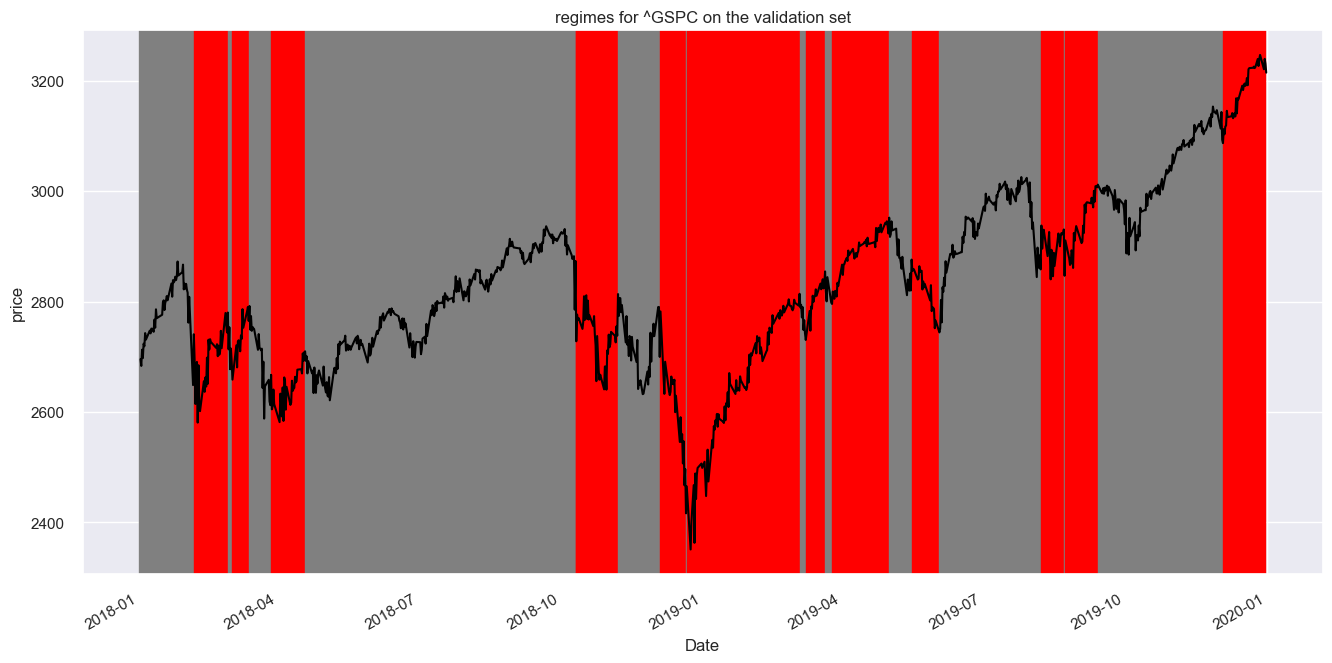

In [ ]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

# Comparing to SVM

In [ ]:
""" Grid for hyperparameter tuning """

parameter_grid = {
    'theta': np.arange(0.01, stop=0.021, step=0.005),
    'DC_indicator': ['R', 'TMV', 'T'],
    'epsilon': [0.6, 0.65, 0.7, 0.75, 0.8],
    'model':['svm']
}

In [ ]:
""" Pull data and run the grid search. We want to maximize profit. """

trading_day = {'equity':12, 'fx':12,'bond':9}
df_ts = get_data('^GSPC', start_date='2005-01-01', delta=trading_day['equity'])
cv3 = CustomCrossValidation(pipeline_class=Pipeline, parameter_grid=parameter_grid, verbose=True)
cv3.fit(data = df_ts, metric='profit', minimize=False)

[*********************100%***********************]  1 of 1 completed
Iteration: 1 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.01}
Iteration: 1 of 45: Training complete.
Iteration: 1 of 45: Loss: {'drawdown': 0.15476858537838412, 'profit': 0.05660923866428269, 'sharpe': 0.27909948638735205}
Iteration: 2 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.015}
Iteration: 2 of 45: Training complete.
Iteration: 2 of 45: Loss: {'drawdown': 0.16062405648755845, 'profit': 0.0879903043994934, 'sharpe': 0.3511267874220865}
Iteration: 3 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.6, 'model': 'svm', 'theta': 0.019999999999999997}
Iteration: 3 of 45: Training complete.
Iteration: 3 of 45: Loss: {'drawdown': 0.17240205914205342, 'profit': 0.07111066491993512, 'sharpe': 0.28659436450957937}
Iteration: 4 of 45: Parameters: {'DC_indicator': 'R', 'epsilon': 0.65, 'model': 'svm', 'theta': 0.01}
Iteration: 4 of 45: Training

In [ ]:
""" Optimal parameters and optimal value of the loss function. """

cv3.get_optimal_loss()

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407,
 'parameters': {'DC_indicator': 'T',
  'epsilon': 0.6,
  'model': 'svm',
  'theta': 0.019999999999999997}}

In [ ]:
""" Fit the model with the optimal parameters found. """

regime_trade = Pipeline(df_ts= df_ts, **cv3.get_optimal_parameters())
regime_trade.fit(verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [ ]:
""" Confirm that the trading metrics match. """
regime_trade.trading_metrics

{'drawdown': 0.173192787639177,
 'profit': 0.21010499133694815,
 'sharpe': 0.495565497339407}

In [ ]:
""" Fit the same model for the control trading strategy."""

control = Pipeline(df_ts= df_ts, strat='control', **cv3.get_optimal_parameters())
control.fit(plot=False, verbose = True)

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


In [ ]:
""" Confirm that there is an improvement when we use the regimes. """

control.trading_metrics

{'drawdown': 0.197107948275105,
 'profit': 0.05202371492608826,
 'sharpe': 0.23050795640032237}

In [ ]:
""" Run the control strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control', **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.2701506503824544,
 'profit': 0.40691312858269235,
 'sharpe': 0.46022959091991317}

In [ ]:
""" Run the control2 strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, strat='control2', **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.25873230856297735,
 'profit': 0.5019380257164072,
 'sharpe': 0.6115277904174444}

In [ ]:
""" Run the strategy on test data. """
strat_test = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
strat_test.fit(verbose = True)
strat_test.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

In [ ]:
""" If you want to get the results in Latex """
# print(cv3.get_results_in_latex(
#     loss_columns=['profit', 'drawdown', 'sharpe'],
#     parameter_columns=['theta', 'epsilon', 'DC_indicator'],
#     caption='SVM Cross-Validation Results'))

' If you want to get the results in Latex '

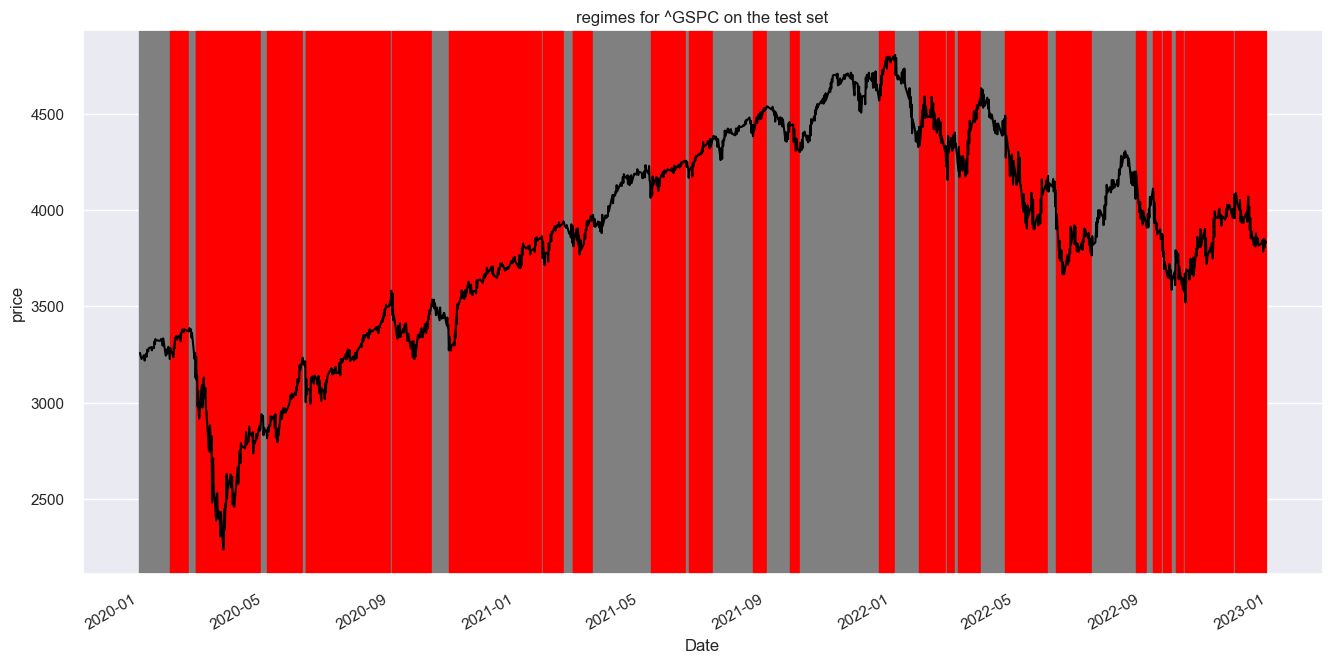

In [ ]:
""" Plot our predicted regimes on the test set. """

regimes = strat_test.regimes_test

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2020-01-01":].plot(ax=ax, color='black')
clr = {0:'grey',1:'red',2:'green'}

# assume default before we see any change
ax.axvspan('2020-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2022-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the test set")
ax.set_ylabel("price")
plt.show()

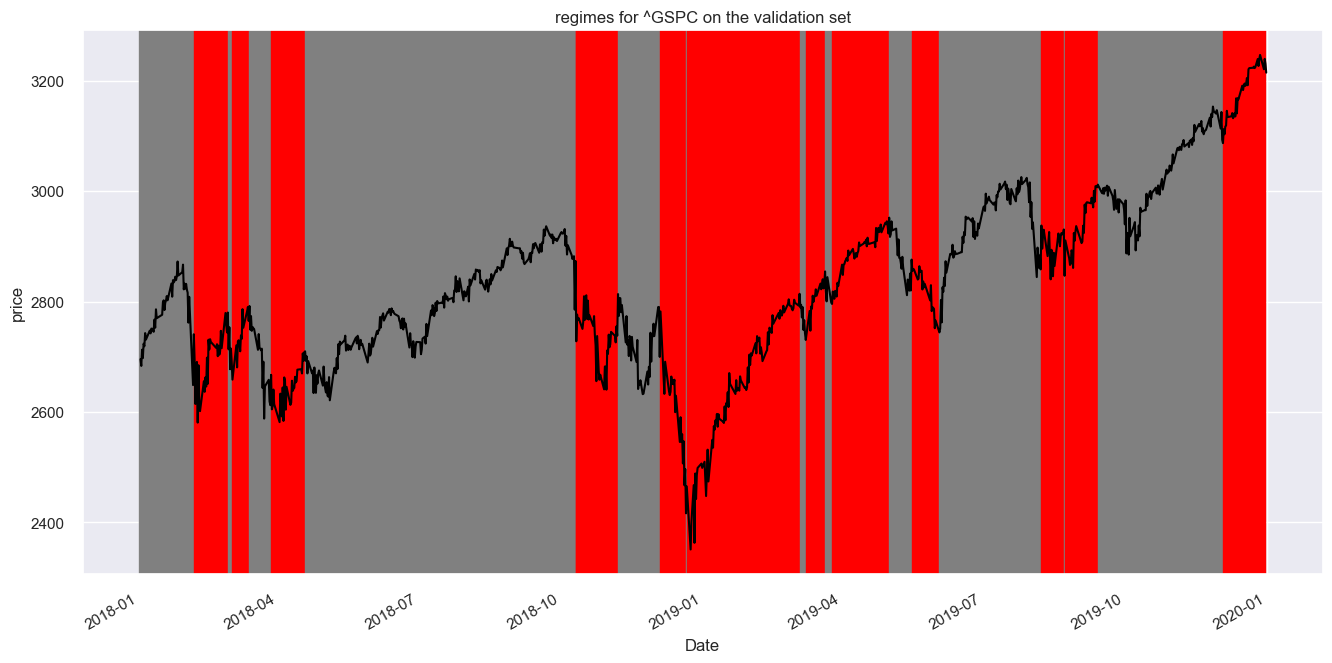

In [ ]:
""" Plot our predicted regimes on the validation set. """

regimes = strat_test.regimes_valid

fig, ax = plt.subplots(figsize=(16,8))
df_ts["2018-01-01":"2019-12-31"].plot(ax=ax, color='black')
clr = {0:'grey',1:'red'}

# assume default before we see any change
ax.axvspan('2018-01-01',regimes.index[0], alpha=1, color=clr[regimes[0]])

# look at the regimes
for time_start, time_end, regime in zip(regimes.index[:-1], regimes.index[1:], regimes.values[:-1]):
    ax.axvspan(time_start,time_end, alpha=1, color=clr[regime])

# propagate last seen regime
ax.axvspan(time_end,"2019-12-31", alpha=1, color=clr[regimes[-1]])

ax.set_title(f"regimes for {strat_test.ticker} on the validation set")
ax.set_ylabel("price")
plt.show()

## Distribution of DCC indicator

In [ ]:
model = Pipeline(df_ts= df_ts, **cv.get_optimal_parameters())
model.fit()

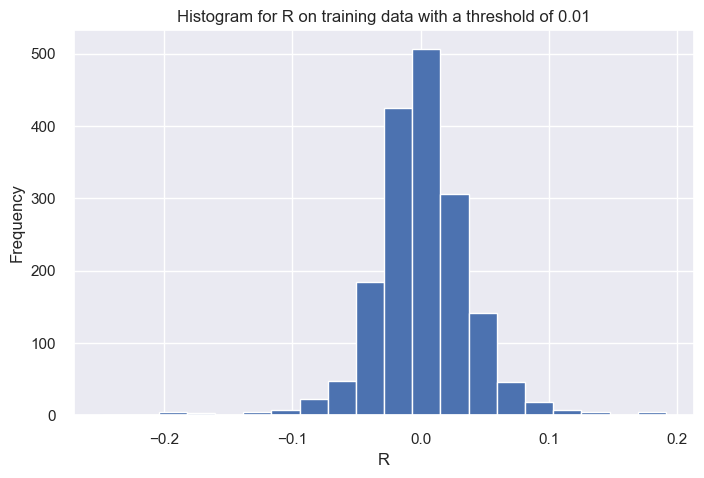

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
model.R['train'].plot.hist(bins=20,ax=ax)
ax.set_title(f"Histogram for R on training data with a threshold of {cv.get_optimal_parameters()['theta']}")
ax.set_xlabel("R")
plt.show()

## Further analysis of SVM and Logistic Regression

In [ ]:
""" Logistic Regression """
lr = Pipeline(df_ts= df_ts, to_test = True, **cv2.get_optimal_parameters())
lr.fit(verbose = True)
lr.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

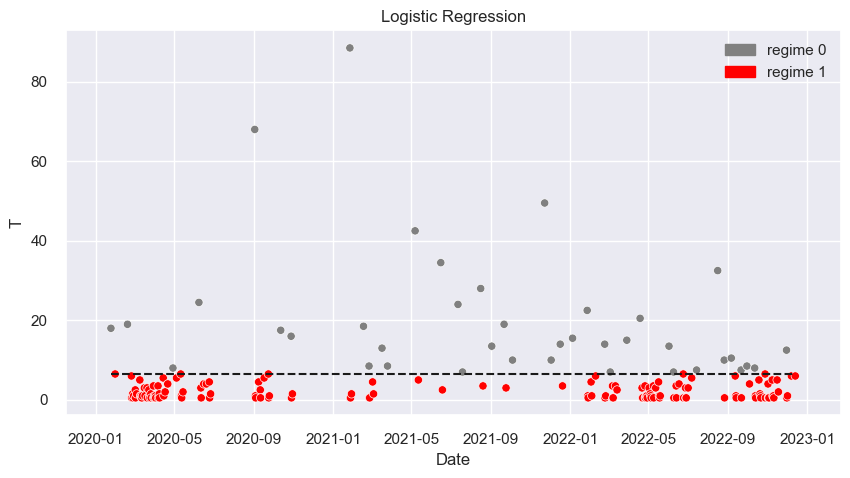

In [ ]:
""" Checking linear separability for Logistic Regression on Test """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=lr.T['test'], c=np.where(lr.regimes_test==1, 'red','gray'))
plt.hlines(np.max(lr.T['test'][lr.regimes_test==1]),xmin=lr.T['test'].index[0],xmax=lr.T['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 0')
red_patch = mpatches.Patch(color='red', label='regime 1')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('T')
ax.set_xlabel('Date')
ax.set_title('Logistic Regression')
None

In [ ]:
""" SVM """
sv = Pipeline(df_ts= df_ts, to_test = True, **cv3.get_optimal_parameters())
sv.fit(verbose = True)
sv.trading_metrics_test

Total duration of time: 396662400.0
Total duration spent in Regime 1: 319291200.0
Proportion of time spent in Regime 1: 0.8049444565454149
Flipping labels between regimes.


{'drawdown': 0.21378587832646642,
 'profit': 0.7527669340261292,
 'sharpe': 0.752857105770566}

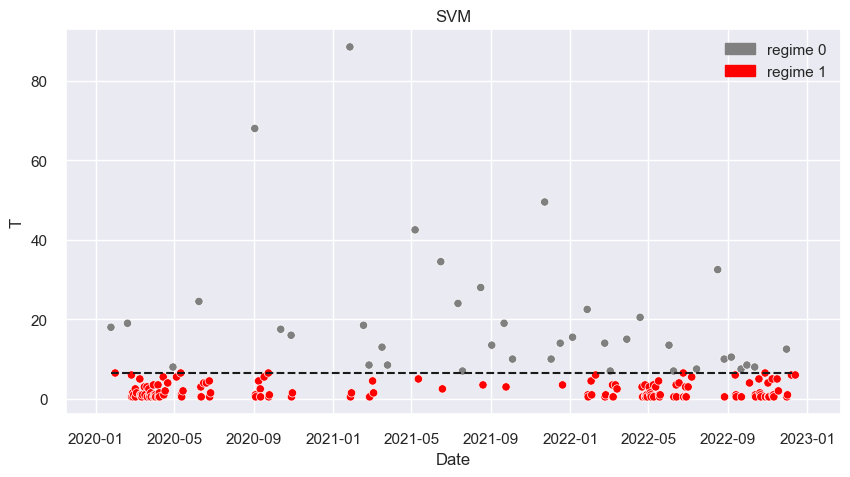

In [ ]:
""" Checking linear separability for SVM Predictions on Validation """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=sv.T['test'], c=np.where(sv.regimes_test==1, 'red','gray'))
plt.hlines(np.max(sv.T['test'][sv.regimes_test==1]),xmin=sv.T['test'].index[0],xmax=sv.T['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 0')
red_patch = mpatches.Patch(color='red', label='regime 1')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('T')
ax.set_xlabel('Date')
ax.set_title('SVM')
None

In [ ]:
""" naive Bayes """
nb = Pipeline(df_ts= df_ts, to_test = True, **cv.get_optimal_parameters())
nb.fit(verbose = True)
nb.trading_metrics_test

Total duration of time: 407764800.0
Total duration spent in Regime 0: 162172800.0
Proportion of time spent in Regime 0: 0.3977116219938553
Flipping labels between regimes.


{'drawdown': 0.25057140523989796,
 'profit': 1.0823749162355516,
 'sharpe': 1.210407488924396}

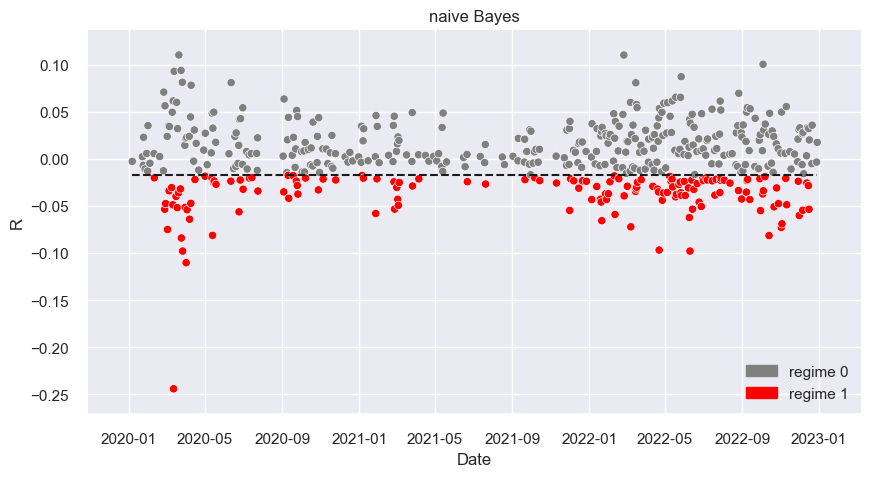

In [ ]:
""" Checking linear separability for naive Bayes Predictions on Validation """
fig,ax = plt.subplots(figsize=(10,5))
sns.scatterplot(data=nb.R['test'], c=np.where(nb.regimes_test==1, 'red','gray'))
plt.hlines(np.max(nb.R['test'][nb.regimes_test==1]),xmin=nb.R['test'].index[0],xmax=nb.R['test'].index[-1], linestyles='dashed')
gray_path = mpatches.Patch(color='gray', label='regime 0')
red_patch = mpatches.Patch(color='red', label='regime 1')
plt.legend(handles=[gray_path, red_patch])
ax.set_ylabel('R')
ax.set_xlabel('Date')
ax.set_title('naive Bayes')
None

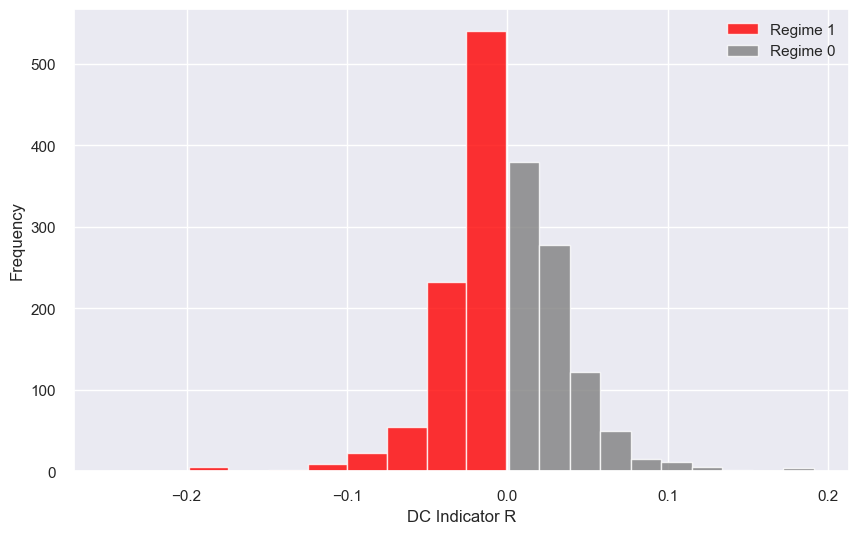

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
nb.R['train'][nb.regimes == 1].plot.hist(ax=ax,alpha=0.8,color='red',label='Regime 1')
nb.R['train'][nb.regimes == 0].plot.hist(ax=ax,alpha=0.8,color='grey', label='Regime 0')
ax.legend()
ax.set_xlabel("DC Indicator R")
plt.show()

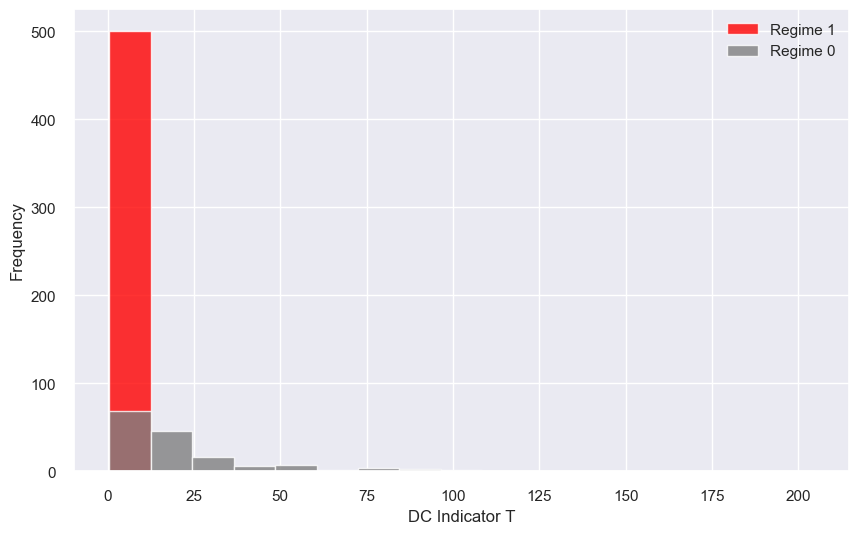

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
lr.T['train'][lr.regimes == 1].plot.hist(ax=ax, bins= np.arange(lr.T['train'].min(),lr.T['train'].max(),12),alpha=0.8,color='red',label='Regime 1')
lr.T['train'][lr.regimes == 0].plot.hist(ax=ax, bins= np.arange(lr.T['train'].min(),lr.T['train'].max(),12),alpha=0.8,color='gray', label='Regime 0')
ax.legend()
ax.set_xlabel("DC Indicator T")
plt.show()